# Tutorial 1: Detecting plankton from video

This tutorial demonstrates how to use LodeSTAR model to detect plankton from video. [LodeSTAR](https://www.nature.com/articles/s41467-022-35004-y) is a deep learning framework which uses self-supervised learning to train a fully convolutional neural network for detecting plankton from microscopy video frames. The training is performed with the help of only a *single* plankton crop from any video frame of users choice.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/softmatterlab/Deep-learning-in-plankton-ecology/blob/main/detection-tutorials/1-detection_plankton1.ipynb)

This tutorial demonstrates how to train LodeSTAR for detecting plankton positions from video frames. It covers information on:

* Loading any experimental video containing plankton
* Selecting plankton crop(s) from any video frame
* Defining and training LodeSTAR model
* Testing the model on the video frames

Run the following cell to install the required python packages to run this tutorial.

In [ ]:
!pip install deeptrack
!pip install tqdm

In [1]:
%matplotlib inline

<!--<badge>--><a href="https://colab.research.google.com/github/softmatterlab/DeepTrack-2.0/blob/develop/examples/LodeSTAR/06.track_plankton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import skimage.color
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
import datetime
import imageio
import deeptrack as dt

In [3]:
def load_video(path, start=0, end=None):
    video= cv2.VideoCapture(path)
    frames=[]
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    if end:
        end = min(end, total_frames)
    else:
        end = total_frames
    for i in tqdm(range(start, end, 1), desc="loading frames"):
        video.set(1, i)
        ret, frame=video.read()
        gray_frame = frame#[:,:,0]
        frames.append(gray_frame)
    return np.array(frames)

In [4]:
path = "../original-videos/Plankton1.mp4"
frames = load_video(path, end=200)

loading frames: 100%|██████████| 200/200 [00:30<00:00,  6.46it/s]


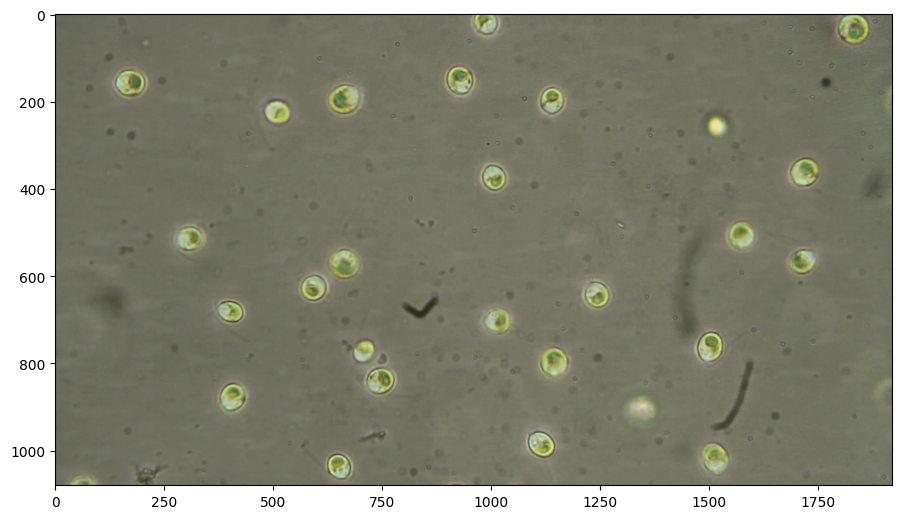

In [6]:
# %matplotlib tk
# To display image in original colors
dpi = 100
frame = frames[0]
plt.figure(figsize=(frame.shape[0]/dpi, frame.shape[1]/dpi), dpi=dpi)
plt.imshow(cv2.cvtColor(frames[0], cv2.COLOR_BGR2RGB))
plt.show()

In [7]:
plankton_positions = [
    [1007, 374],
    [1241, 645],
    [1502, 762],
    [506, 220],
    [167, 159]
]

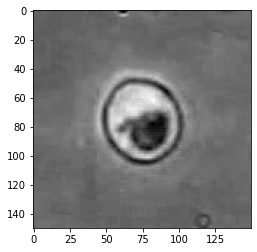

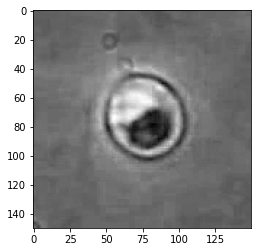

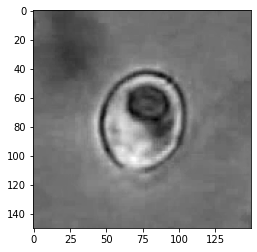

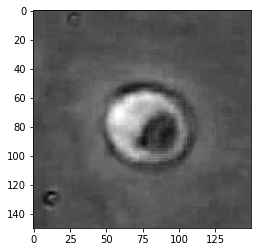

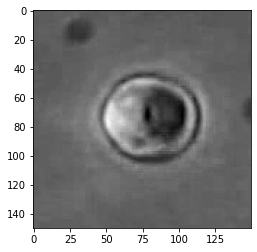

In [8]:
crop_width = 150
crops = []
for pos in plankton_positions:
    crop = frame[int(pos[1] - crop_width/2) :int(pos[1] + crop_width/2), int(pos[0] - crop_width/2) : int(pos[0] + crop_width/2)][:,:,0]
    crops.append(crop)
    plt.imshow(crop, cmap="gray")
    plt.show()
crops = np.expand_dims(crops, axis=-1)

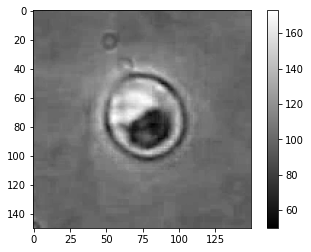

In [9]:
import random
# random.seed(20)
crop = random.choice(crops)
plt.imshow(crop, cmap="gray")
plt.colorbar()

In [10]:
random_crop = dt.Value(lambda: random.choice(crops))

In [11]:
downsample = 2

In [31]:
TRAIN = True

if TRAIN:
    model = dt.models.LodeSTAR(input_shape=(None, None, 1))
    train_set =   (
        dt.Value(random_crop)
        >> dt.AveragePooling(ksize=(downsample, downsample, 1))
        # >> dt.Affine(rotate=lambda: np.random.rand()*np.pi*2, scale=lambda:np.random.uniform(0.95, 1.05, 2))
        # >> dt.Add(lambda: np.random.randn() * 0.2)
        # >> dt.Gaussian(sigma=lambda:np.random.uniform(0, 0.01))  
        # >> dt.Multiply(lambda: np.random.uniform(0.3, 1.6))
    )

    model.fit(
        train_set,
        epochs=15,
        batch_size=8,
        verbose=1
    )

    model.model.model.save_weights("../pre-trained-models/lodestar-model-plankton1.h5")

else:
    model = dt.models.LodeSTAR(input_shape=(None, None, 1))
    model.model.model.load_weights("../pre-trained-models/lodestar-model-plankton1.h5")

Generating 166 / 160 samples before starting training
Epoch 1/15


2022-10-18 18:21:16.122669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


167/167 [==============================] - 9s 40ms/step - total_loss: 4.3929 - consistency_loss: 2.8155
Epoch 2/15
167/167 [==============================] - 6s 38ms/step - total_loss: 4.4612 - consistency_loss: 2.8695
Epoch 3/15
167/167 [==============================] - 6s 38ms/step - total_loss: 4.1685 - consistency_loss: 2.6316
Epoch 4/15
167/167 [==============================] - 7s 41ms/step - total_loss: 4.0446 - consistency_loss: 2.2909
Epoch 5/15
167/167 [==============================] - 7s 42ms/step - total_loss: 1.9331 - consistency_loss: 1.1946
Epoch 6/15
167/167 [==============================] - 6s 36ms/step - total_loss: 0.9979 - consistency_loss: 0.7129
Epoch 7/15
167/167 [==============================] - 7s 43ms/step - total_loss: 0.6924 - consistency_loss: 0.4747
Epoch 8/15
167/167 [==============================] - 7s 44ms/step - total_loss: 0.3057 - consistency_loss: 0.1071
Epoch 9/15
167/167 [==============================] - 8s 46ms/step - total_loss: 0.1770 - c

In [32]:
crop2 = np.expand_dims(crop, axis=0)

In [33]:
p, w = model.predict(crop2)

1/1 [==============================] - 0s 258ms/step


2022-10-18 18:23:25.330291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


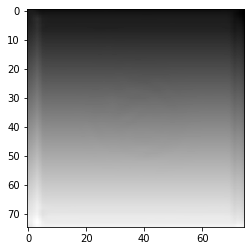

In [34]:
plt.imshow(p[0,:,:,0], cmap="gray")

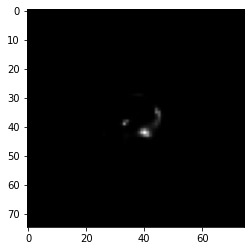

In [35]:
plt.imshow(w[0,:,:,0], cmap="gray")

In [39]:
#May need to tune these to get optimal performance!
alpha = 1
cutoff = 0.1

starting_frame = 0
ending_frame = len(frames)

frames2 = np.expand_dims(frames[:,:,:,0], axis=-1)
detections = model.predict_and_detect(frames2[starting_frame:ending_frame, ::downsample, ::downsample, :1], alpha=alpha, beta=1-alpha, cutoff=cutoff, mode="constant")


7/7 [==============================] - 36s 4s/step


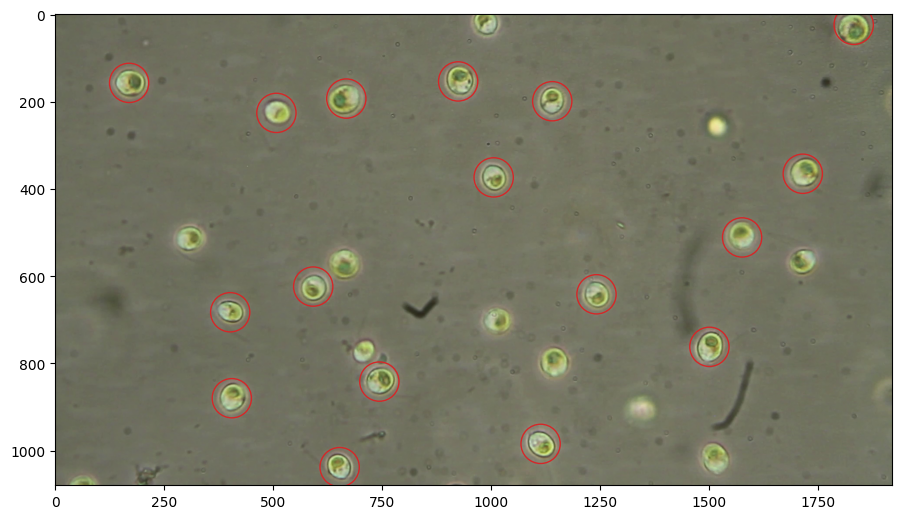

In [40]:
frame_no = 0
plt.figure(figsize=(frame.shape[0]/dpi, frame.shape[1]/dpi), dpi=dpi)
plt.imshow(cv2.cvtColor(frames[frame_no], cv2.COLOR_BGR2RGB))
plt.scatter(detections[frame_no][:,1] * downsample , detections[frame_no][:,0] * downsample, s = 800, facecolors="none", edgecolors="tab:red")

In [41]:
_dpi = 200
images = []
path = "../detection-videos/Detection-Plankton1.mp4"

for i in range(len(frames)):
    fig, ax = plt.subplots(
        figsize=(frame.shape[1]/ _dpi, frame.shape[0] / _dpi), dpi=_dpi, frameon=False
    )
    ax.set_axis_off()
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)
    plt.margins(0, 0)
    plt.imshow(cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB), origin="upper")
    plt.scatter(
        detections[i][:, 1] * downsample,
        detections[i][:, 0] * downsample,
        s=800,
        facecolors="none",
        edgecolors="tab:red",
    )
    fig.canvas.draw()
    arr = np.array(fig.canvas.renderer.buffer_rgba())
    images.append(arr)

    fig.clear()
    plt.close(fig)
    plt.show()

imageio.mimsave(path, images, fps=30)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1920, 1080) to (1920, 1088) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
